In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import datetime
from tqdm import tqdm
import argparse, os, math
import numpy as np
from hpcp_loader_for_softdtw import *
import models.BaseSPPNet as models
from config import DefaultConfig, opt
from utility import *
import json
import torch.nn.functional as F
from torch.nn import *
import pandas as pd
import seaborn as sns
import resource
import librosa

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

In [92]:
save_dir = None
saved_model_path = './experiment/0.5.1/model_best.pth'
lr = 1e-6
weight_decay = 0
num_workers = 0
epochs = 100
epochs_finished = 0
BATCH_SIZE = 10
device_ids = [0]
datatype = 'multif0_avg5'
train_scale = 'so_short'
test_scale = 'so_short'
test_source = 'gdoras_train'
train_cut = 'front'

In [93]:
model = models.NeuralDTW_CNN_Mask_dilation_SPP6(None)
model = model.cuda()
model = nn.DataParallel(model)

if saved_model_path != None:
    print(f'loading model from {saved_model_path}...')
    model.load_state_dict(torch.load(saved_model_path))

loss_fn = nn.BCELoss() # loss_fn返回的值已经对每个样本做平均了
loss_fn = loss_fn.cuda()
loss_fn = nn.DataParallel(loss_fn)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10,
                                                               verbose=True, min_lr=5e-10)

loading model from ./experiment/0.5.1/model_best.pth...


In [ ]:
# Xavier init
from torch.nn import init
#define the initial function to init the layer's parameters for the network

def initNetParams(net):
    '''Init net parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform(m.weight)
            if m.bias != None:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias != None:
                init.constant(m.bias, 0)

initNetParams(model)

In [94]:
# Dataloader
print(f'{datetime.datetime.now()} - Preparing train_dataloader...')
train_data = triplet_CQT(out_length=400, is_label=True, mode=(datatype, train_scale), cut=train_cut, is_random=True)
train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=False, num_workers=num_workers)

print(f'{datetime.datetime.now()} - Preparing test_dataloader...')
test_data = CQT(mode=(test_source, datatype, test_scale), out_length=400)
test_dataloader = DataLoader(test_data, 1, shuffle=False, num_workers=num_workers)

2021-10-12 19:27:56.741738 - Preparing train_dataloader...
2021-10-12 19:27:56.743375 - Preparing test_dataloader...


for i in range(a.shape[0]):
    plt.imshow(a[i,0].cpu(), origin='lower')
    plt.show()

for a, la in test_dataloader:
    plt.imshow(a[0,0].cpu(), origin='lower')
    plt.show()

In [95]:
for a,p,n,la,lp,ln in train_dataloader:
    break

a, p, n = a.cuda(device=device_ids[0]), p.cuda(device=device_ids[0]), n.cuda(device=device_ids[0])

a.shape

model.eval()
model.module.model.eval()

with torch.no_grad():
    out = model(a,p,n).squeeze(0)
    print(out)

B, _, _, _ = a.shape
target = torch.cat((torch.ones(B), torch.zeros(B))).cuda()

loss_fn(out.squeeze(1), target)

tensor([[0.6465],
        [0.6506],
        [0.5313],
        [0.4604],
        [0.4884],
        [0.5040],
        [0.5898],
        [0.5896],
        [0.5154],
        [0.3741],
        [0.4077],
        [0.4770]], device='cuda:0')


tensor(0.6519, device='cuda:0')

In [76]:
@torch.no_grad()
def val_quick(softdtw, dataloader):
    softdtw.eval()
    softdtw.module.model.eval()
    labels = []
    temp = []
    count = -1
    for ii, (data, label) in tqdm(enumerate(dataloader)):
        labels.append(label)
    labels = torch.cat(labels, dim=0) # labels: 库里每首歌的song_id
    N = labels.shape[0]
    dis2d = np.zeros((N, N))
    for ii, (data, label) in tqdm(enumerate(dataloader)):
        data = data.cuda(device=device_ids[0])
        count += 1
        if count == 0: # for中的第一轮循环
            temp.append((data, count)) # temp[0] = (data, 0)
        else:
            for i in range(len(temp)):
                dis = softdtw.module.multi_compute_s(data, temp[i][0]).data.cpu().numpy()
                dis2d[temp[i][1]][count], dis2d[count][temp[i][1]] = -dis, -dis
            temp.append((data, count))

    MAP, top10, rank1 = calc_MAP(dis2d[0:labels.shape[0], 0:labels.shape[0]], labels)
    print(f'MAP:\t{MAP:.4f}\ttop10:\t{top10:.4f}\trank1:\t{rank1:.4f}')
    softdtw.train()
    softdtw.module.model.train()
    return MAP

In [77]:
@torch.no_grad()
def val_slow_batch(softdtw, dataloader, batch=50, is_dis=False):
    softdtw.eval()
    softdtw.module.model.eval()
    seqs, labels = [], []
    for ii, (data, label) in tqdm(enumerate(dataloader)):
        input = data.cuda(device=device_ids[0])
        seqs.append(input)
        labels.append(label)
    seqs = torch.cat(seqs, dim=0)
    labels = torch.cat(labels, dim=0)
    N = labels.shape[0]
    if N == 350:
        query_l = [i // 100 for i in range(100 * 100, 350 * 100)]
        ref_l = [i for i in range(100)] * 250
    else:
        query_l = [i // N for i in range(N * N)] # [0,...,0,1,...,1,...,N,...,N]
        ref_l = [i for i in range(N)] * N # [0,...,N,0,...,N,...,0,...,N]
    dis2d = np.zeros((N, N))

    N = N * N if N != 350 else 100 * 250 # N = N*N
    for st in tqdm(range(0, N, batch)):
        fi = (st + batch) if st + batch <= N else N
        query = seqs[query_l[st: fi], :, :]
        ref = seqs[ref_l[st: fi], :, :]
        s = softdtw.module.multi_compute_s(query, ref).data.cpu().numpy()
        for k in range(st, fi):
            i, j = query_l[k], ref_l[k]
            if is_dis:
                dis2d[i, j] = s[k - st]
            else:
                dis2d[i, j] = -s[k - st]
#     print(labels)
#     print(dis2d)
    if len(labels) == 350:
        MAP, top10, rank1 = calc_MAP(dis2d, labels, [100, 350])
    else:
        MAP, top10, rank1 = calc_MAP(dis2d, labels)
    print(f'MAP:\t{MAP:.4f}\ttop10:\t{top10:.4f}\trank1:\t{rank1:.4f}')

    softdtw.train()
    softdtw.module.model.train()
    return MAP, dis2d

6it [00:00, 546.47it/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

MAP:	0.9444	top10:	0.2000	rank1:	1.0000


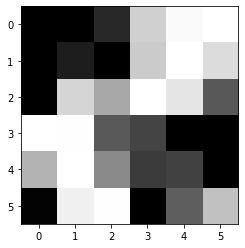

In [78]:
MAP, dis2d = val_slow_batch(model, test_dataloader)

plt.imshow(dis2d, cmap='gray')

In [ ]:
# 一个epoch的训练/测试
def train(dataloader, model, loss_fn, optimizer, scheduler):
    model.train()
    model.module.model.train()
    
    size = len(dataloader.dataset)
    batch_num = math.ceil(size/dataloader.batch_size)
    
    loss_total = 0
    num = 0
    
    for batch, (a, p, n, la, lp, ln) in tqdm(enumerate(dataloader)):
        B, _, _, _ = a.shape
        target = torch.cat((torch.ones(B), torch.zeros(B))).cuda()
        a, p, n = a.cuda(device=device_ids[0]), p.cuda(device=device_ids[0]), n.cuda(device=device_ids[0])
        optimizer.zero_grad()
        pred = model(a, p, n)
        pred = pred.squeeze(1)
#         print(pred, target)
        loss = loss_fn(pred, target)
        loss = loss.sum()
#         print(loss)
        loss.backward()
#         print(list(model.named_parameters())[24][1][0,0,0])
#         print(list(model.named_parameters())[24][1].grad[0,0,0])
        
        optimizer.step()
#         print(list(model.named_parameters())[24][1][0,0,0])
        loss_total += loss.item()
        num += B

        if (batch+1) % 100 == 0:
            print(f"Avg loss: {loss.item():.4f}  [{num:>5d}/{size:>5d}]")
            scheduler.step(loss.item())

    return loss_total/batch_num

In [ ]:
## best_MAP = val_slow_batch(model, test_dataloader)
best_MAP = 0

# try:
#     print(list(model.named_parameters())[24][1].grad[0,0,0])
# except:
#     pass
# print(list(model.named_parameters())[24][1][0,0,0])

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------{datetime.datetime.now()}")
    train_loss = train(train_dataloader, model, loss_fn, optimizer, scheduler)
    print(f'train_loss:{train_loss:.6f}')

    MAP = 0
    print('gdoras_test:')
    MAP += val_slow_batch(model, test_dataloader)
    if MAP > best_MAP:
        print('*****************BEST*****************')
        print(f'[epoch {t+1}] {best_MAP:.4f} --- {MAP:.4f}. Save.')
        best_MAP = MAP
#         torch.save(model.state_dict(), os.path.join(save_dir, f'model_best.pth'))
    
    if optimizer.state_dict()['param_groups'][0]['lr']<=0:
        print(f'Early stop after {t+1} epochs.')
        break
    
print('Done!')

In [ ]:

# 有问题！！！
@torch.no_grad()
def test(dataloader, model, loss_fn):
    # only see loss
    model.eval()
    model.module.model.eval()
    
    size = len(dataloader.dataset)
    batch_num = math.ceil(size/dataloader.batch_size)
    loss_total = 0
    
    for batch, (a, p, n, la, lp, ln) in tqdm(enumerate(dataloader)):
            B, _, _, _ = a.shape
            target = torch.cat((torch.ones(B), torch.zeros(B))).cuda()
            a, p, n = a.cuda(device=device_ids[0]), p.cuda(device=device_ids[0]), n.cuda(device=device_ids[0])
            pred = model(a, p, n)
            pred = pred.squeeze(1)
            loss = loss_fn(pred, target)
            loss = loss.sum()
            loss.backward()
            loss_total += loss.item()
            
    return loss_total/batch_num